In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Multinomial naive bayes

In [42]:
df = pd.read_csv("data/prepared_data.csv")

In [43]:
df.shape

(255082, 10)

### 1. Prepare data

In [44]:
X = df['cleaned_text']
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Vectorize text

In [45]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [46]:
# If we want to see the vectorization
X_array = X_train_tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()
print("Feature Names (Vocabulary):")
print(feature_names)
print("\nTF-IDF Matrix:")
print(X_array)

Feature Names (Vocabulary):
['aa' 'aaa' 'aaaa' ... 'zzzzzzzz' 'zzzzzzzzzz' 'ítem']

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 3. Train a model 

In [47]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

### 4. Evaluate the model

In [48]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.66      0.80      0.72     17993
           0       0.59      0.20      0.29     12600
           1       0.67      0.83      0.74     20424

    accuracy                           0.66     51017
   macro avg       0.64      0.61      0.59     51017
weighted avg       0.65      0.66      0.62     51017



           Predicted -1  Predicted 0  Predicted 1
Actual -1         14370          823         2800
Actual 0           4731         2482         5387
Actual 1           2637          931        16856


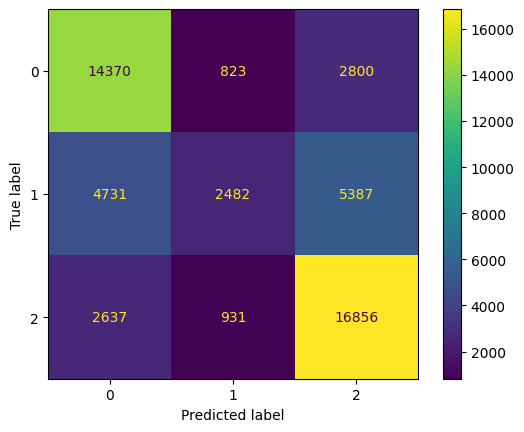

In [49]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()